In [14]:
import numpy as np
import torch
import sys

sys.path.append("../../")
from vi_rnn.vae import VAE
from vi_rnn.train import train_VAE
from vi_rnn.datasets import SineWave, Oscillations_Poisson
from torch.utils.data import DataLoader
from py_rnn.model import RNN
from vi_rnn.utils import *
from py_rnn.train import train_rnn
from py_rnn.train import save_rnn, load_rnn
import matplotlib.pyplot as plt
from vi_rnn.saving import save_model
from py_rnn.default_params import get_default_params

%matplotlib inline

In [15]:
train_teacher = False  # load already trained teacher model
data_dir = "../../data/student_teacher/"  # store inferred model
model_dir = "../../models/students/"  # store teacher RNN
cuda = True  # toggle if GPU is available

In [16]:
# initialise teacher RNN
model_params, training_params = get_default_params(n_rec=40)
training_params["l2_rates_reg"] = 0.1
rnn_osc = RNN(model_params)


# initialise teacher RNN's task
task_params = {
    "n_trials": 50,
    "dur": 200,
    "n_cycles": 4,
}
sine_task = SineWave(task_params)
x, y, m = sine_task[0]

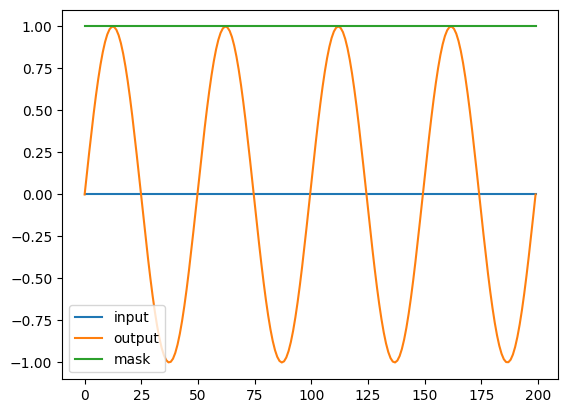

In [17]:
# Plot teacher task
plt.plot(x, label="input")
plt.plot(y, label="output")
plt.plot(m, label="mask")
plt.legend()

In [18]:
if train_teacher:
    losses, reg_losses = train_rnn(
        rnn_osc, training_params, sine_task, sync_wandb=False
    )
    save_rnn(
        data_dir + "osc_rnn_poisson_new",
        rnn_osc,
        model_params,
        task_params,
        training_params,
    )
else:
    rnn_osc, model_params, task_params, training_params = load_rnn(
        data_dir + "/osc_rnn_poisson"
    )

In [19]:
# Extract weights
U, V, B = extract_orth_basis_rnn(rnn_osc)

In [20]:
# plot example trial plus the latent signal underlying it
task_params = {
    "dur": 200,
    "n_trials": 400,
    "name": "Sine",
    "n_neurons": 40,
    "out": "currents",
    "w": 0.1,
    "R_z": 0.2,
    "Bias": -3,
    "B": 4,
    "non_lin": torch.nn.ReLU(),
    "obs_rectify": "softplus",
}
task = Oscillations_Poisson(task_params, U, V, B)
batch_size = 10
data_loader = DataLoader(task, batch_size=batch_size, shuffle=True)

In [8]:
# np.save("../../tutorial/tutorial_data/spiking_data_trials.npy",task.data)

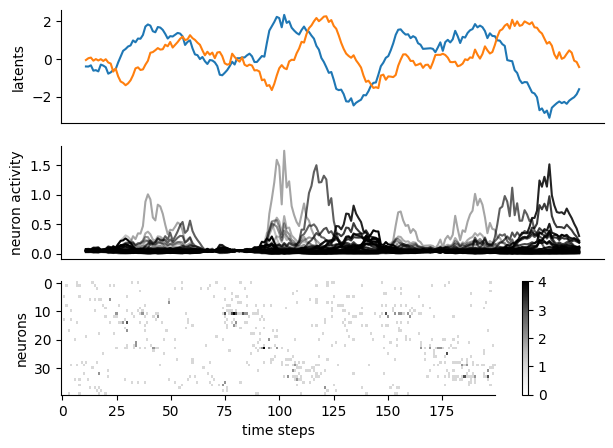

In [21]:
# plot example trial plus the latent signal underlying it

tr_i = 0
rates = task.data[tr_i]
logrates = task.rates[tr_i]
latent_code = task.latents[tr_i]
fig, ax = plt.subplots(3, figsize=(7, 5))
indices = np.argsort(np.argmax(logrates[:, -50:], 1))
im = ax[2].imshow(rates[indices], aspect="auto", interpolation="none", cmap="Greys")
fig.colorbar(im)
for i, ind in enumerate(indices.numpy()):
    ax[1].plot(logrates[ind], alpha=np.linspace(0.1, 1, 40)[i], color="black")

ax[0].plot(latent_code[0])
ax[0].plot(latent_code[1])
ax[2].set_xlabel("time steps")
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_ylabel("neurons")
ax[1].set_ylabel("neuron activity")
ax[0].set_ylabel("latents")

ax[0].spines[["right", "top"]].set_visible(False)
ax[1].spines[["right", "top"]].set_visible(False)
ax[2].spines[["right", "top"]].set_visible(False)

In [22]:
print(
    "mean spike rate in Hz, assuming 20 ms bins: " + str(task.data.float().mean() * 50)
)

mean spike rate in Hz, assuming 20 ms bins: tensor(4.3825)


In [33]:
a = task.data_eval
b = task.data


In [11]:
vars(task)

{'dur': 200,
 'n_trials': 400,
 'N': 40,
 'non_lin': ReLU(),
 'R_z': 0.2,
 'task_params': {'dur': 200,
  'n_trials': 400,
  'name': 'Sine',
  'n_neurons': 40,
  'out': 'currents',
  'w': 0.1,
  'R_z': 0.2,
  'Bias': -3,
  'B': 4,
  'non_lin': ReLU(),
  'obs_rectify': 'softplus'},
 'latents': tensor([[[ 0.9489,  1.6119,  1.7163,  ..., -1.3014, -1.1494, -1.1465],
          [-3.9648, -3.8490, -3.7563,  ..., -2.6526, -2.5511, -2.5011]],
 
         [[-0.9777, -0.9985, -0.8539,  ..., -0.5051, -0.0640,  0.0499],
          [-0.5436, -0.5975, -0.7436,  ..., -1.2826, -1.1376, -0.8525]],
 
         [[-0.6601, -0.3531,  0.1444,  ...,  0.6797,  0.9897,  1.3379],
          [-0.8976, -0.6617, -0.5104,  ...,  0.3750,  0.4612,  1.0277]],
 
         ...,
 
         [[-1.7273, -1.3702, -1.0479,  ..., -0.1326,  0.0989, -0.1006],
          [-3.2965, -3.2706, -3.3695,  ...,  1.4313,  1.4597,  1.5779]],
 
         [[-3.3089, -3.6744, -3.6261,  ...,  1.2286,  1.5868,  1.6410],
          [ 0.9035,  0.4490,  0.

## Create a VAE RNN setup

In [37]:
# Initialise VI / student setup

dim_z = 2
dim_N = 40
dim_x = task_params["n_neurons"]
bs = 10
cuda = False
n_epochs = 1500
wandb = False
# initialise encoder
enc_params = {
    "init_kernel_sizes": [21, 11, 1],
    "nonlinearity": "gelu",
    "n_channels": [64, 64],
    "init_scale": 0.1,
    "constant_var": False,
    "padding_mode": "circular",
    "padding_location": "causal",
}


# initialise prior
rnn_params = {
    "transition": "low_rank",
    "observation": "one_to_one",
    "train_noise_z": True,
    "train_noise_z_t0": True,
    "init_noise_z": 0.1,
    "init_noise_z_t0": 1,
    "noise_z": "diag",
    "noise_z_t0": "diag",
    "identity_readout": True,
    "activation": "relu",
    "decay": 0.9,
    "readout_from": task_params["out"],
    "train_obs_bias": True,
    "train_obs_weights": True,
    "train_neuron_bias": True,
    "weight_dist": "uniform",
    "weight_scaler": 1,  # /dim_N,
    "initial_state": "trainable",
    "obs_nonlinearity": task_params["obs_rectify"],
    "obs_likelihood": "Poisson",
    "simulate_input": False,
}


training_params = {
    "lr": 1e-3,
    "lr_end": 1e-5,
    "grad_norm": 0,
    "n_epochs": n_epochs,
    "eval_epochs": 50,
    "batch_size": bs,
    "cuda": cuda,
    "smoothing": 20,
    "freq_cut_off": 10000,
    "k": 64,
    "loss_f": "smc",
    "resample": "systematic",  # , multinomial or none"
    "run_eval": True,
    "smooth_at_eval": False,
    "t_forward": 0,
    "init_state_eval": "posterior_sample",
}


VAE_params = {
    "dim_x": dim_x,
    "dim_z": dim_z,
    "dim_N": dim_N,
    "enc_architecture": "CNN",
    "enc_params": enc_params,
    "rnn_params": rnn_params,
}
vae = VAE(VAE_params)

using uniform init
torch.Size([40, 0])
using causal circular padding


## Train the VAE

In [13]:
# Train
wandb = False
train_VAE(vae, training_params, task, sync_wandb=wandb, out_dir=model_dir, fname=None)

Training on : cpu
Learning rate decay factor 0.9969345945217527
n outliers: 0.0
KL_x = 8.600, PS_dist = 0.472, Mean_rate_error = 79089025873136.844


KeyboardInterrupt: 

In [ ]:
save_model(vae, training_params, task_params, name=model_dir + "Sine_40_1000_new")